🔽 Téléchargement de la base ORL...
✅ Téléchargement terminé.
📦 Extraction du .tar...
✅ Base ORL prête à l'emploi dans 'orl_faces' !
Chargement des images...
✅ Dossier de visages trouvé à: orl_faces/orl_faces
Nombre de dossiers sujets trouvés: 40


Chargement des sujets: 100%|██████████| 40/40 [00:00<00:00, 212.79it/s]

Traitement du sujet s34: 10 images
Traitement du sujet s38: 10 images
Traitement du sujet s37: 10 images
Traitement du sujet s8: 10 images
Traitement du sujet s18: 10 images
Traitement du sujet s10: 10 images
Traitement du sujet s3: 10 images
Traitement du sujet s12: 10 images
Traitement du sujet s21: 10 images
Traitement du sujet s5: 10 images
Traitement du sujet s20: 10 images
Traitement du sujet s4: 10 images
Traitement du sujet s6: 10 images
Traitement du sujet s23: 10 images
Traitement du sujet s11: 10 images
Traitement du sujet s35: 10 images
Traitement du sujet s31: 10 images
Traitement du sujet s39: 10 images
Traitement du sujet s25: 10 images
Traitement du sujet s17: 10 images
Traitement du sujet s36: 10 images
Traitement du sujet s14: 10 images
Traitement du sujet s13: 10 images
Traitement du sujet s22: 10 images
Traitement du sujet s30: 10 images
Traitement du sujet s7: 10 images
Traitement du sujet s27: 10 images
Traitement du sujet s2: 10 images
Traitement du sujet s1: 10 

Dimensions finales: X = (400, 10304), y = (400,)
Affichage de quelques images...


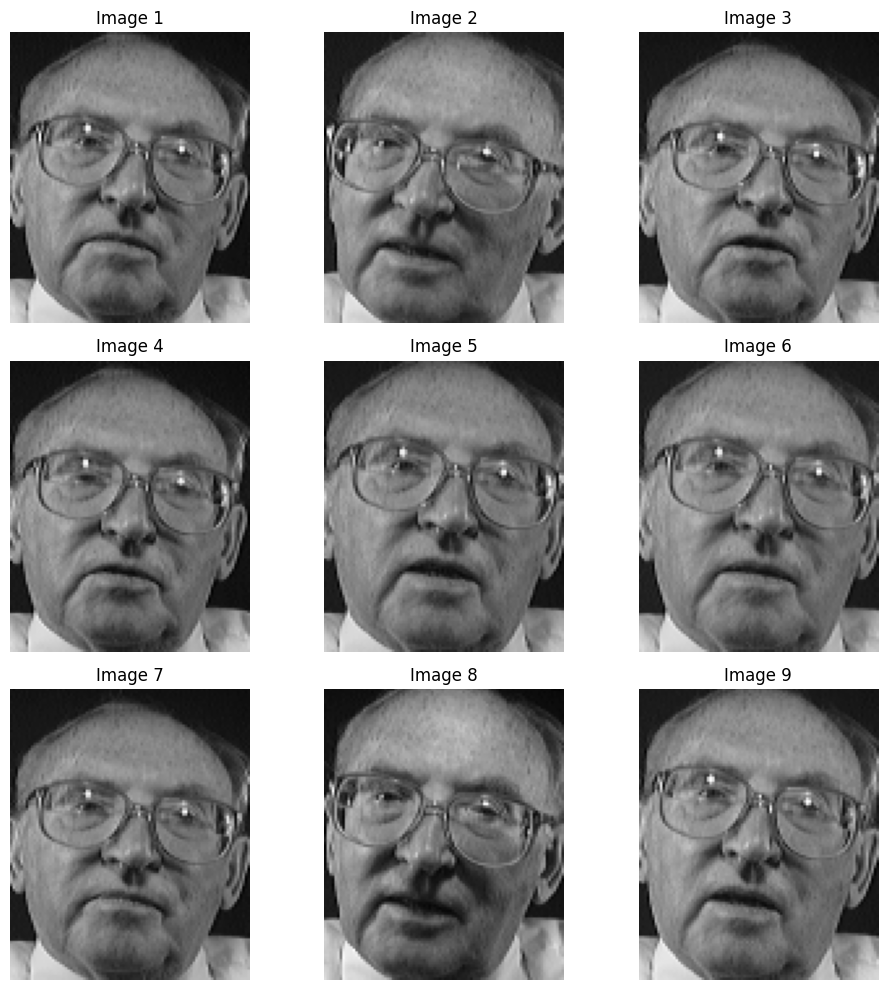

Calcul de la PCA...
Utilisation de 100 composantes PCA
Classification KNN...
Précision globale: 93.00%

Rapport de classification:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.75      1.00      0.86         3
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       0.75      1.00      0.86         3
           9       0.67      1.00      0.80         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         3
    

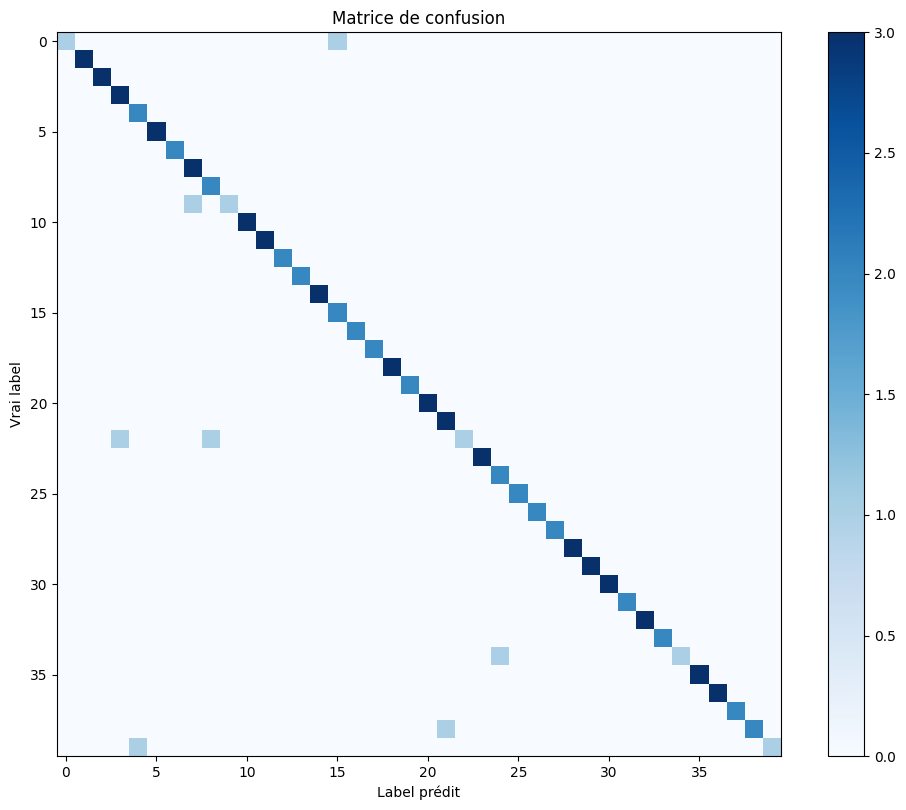


Affichage de quelques prédictions...


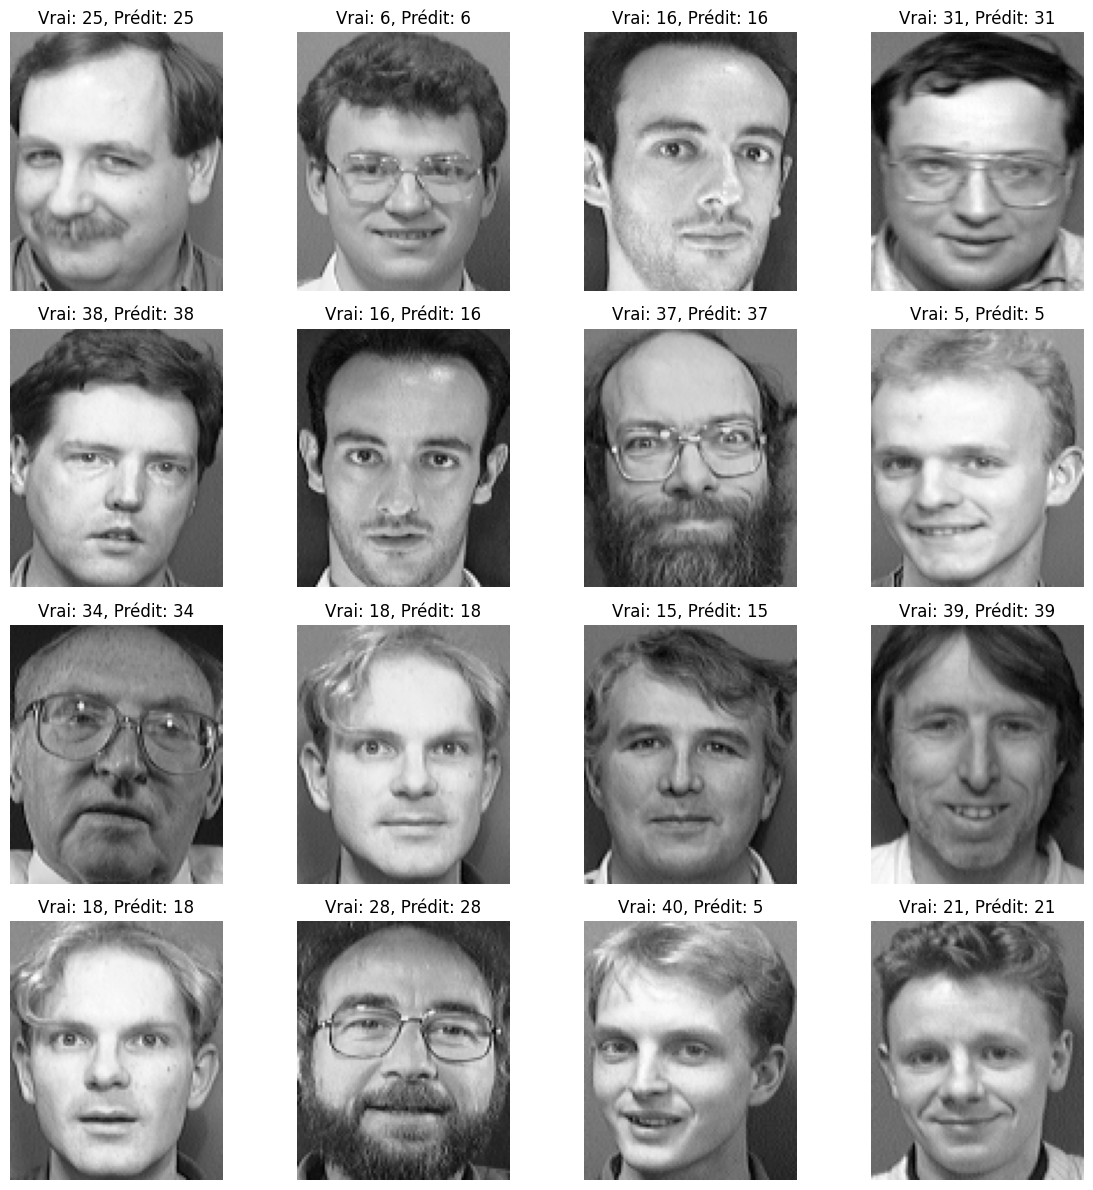

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import tarfile
import subprocess
import shutil
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
from tqdm import tqdm

def download_and_extract_orl_faces():
    """Télécharger et extraire la base ORL des visages"""
    url = "https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z"
    archive_name = "att_faces.tar.Z"
    tar_name = "att_faces.tar"
    extracted_folder = "orl_faces"

    if not os.path.exists(extracted_folder):
        print("🔽 Téléchargement de la base ORL...")
        urlretrieve(url, archive_name)
        print("✅ Téléchargement terminé.")

        # Décompresser le fichier .Z
        if os.name == 'posix':  # Linux/Mac
            subprocess.run(["uncompress", archive_name])
        else:  # Windows ou autre
            try:
                import py7zr
                with py7zr.SevenZipFile(archive_name, 'r') as z:
                    z.extractall()
            except ImportError:
                print("⚠️ Module py7zr non trouvé. Installation...")
                subprocess.run(["pip", "install", "py7zr"])
                import py7zr
                with py7zr.SevenZipFile(archive_name, 'r') as z:
                    z.extractall()

        print("📦 Extraction du .tar...")
        with tarfile.open(tar_name, "r") as tar:
            tar.extractall(path=extracted_folder)

        print("✅ Base ORL prête à l'emploi dans 'orl_faces' !")
    else:
        print("📂 La base ORL est déjà présente.")

def read_pgm_manual(filename):
    """Lire manuellement un fichier PGM"""
    with open(filename, 'rb') as f:
        # Lire l'en-tête
        header = f.readline().decode().strip()

        # Ignorer les commentaires
        line = f.readline().decode().strip()
        while line.startswith('#'):
            line = f.readline().decode().strip()

        # Lire les dimensions
        width, height = map(int, line.split())

        # Lire la valeur max
        max_val = int(f.readline().decode().strip())

        # Lire les données d'image
        if header == 'P5':  # Format binaire
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
        else:  # Format ASCII (P2)
            image_data = np.array([int(val) for val in f.read().split()])

        # Redimensionner et normaliser
        try:
            image = image_data.reshape((height, width)) / max_val
            return image
        except ValueError:
            # Si le reshape échoue, essayer une autre approche
            expected_size = height * width
            if len(image_data) >= expected_size:
                image = image_data[:expected_size].reshape((height, width)) / max_val
                return image
            raise ValueError(f"Impossible de redimensionner l'image {filename}")

def load_orl_faces():
    """Charger les visages ORL"""
    # Vérifier si le dossier existe
    if not os.path.exists("orl_faces"):
        raise FileNotFoundError("Le dossier 'orl_faces' n'existe pas. Exécutez d'abord download_and_extract_orl_faces().")

    # Déterminer le chemin correct
    potential_paths = [
        os.path.join("orl_faces", "att_faces"),
        os.path.join("orl_faces", "orl_faces"),
        "orl_faces"
    ]

    folder = None
    for path in potential_paths:
        if os.path.exists(path):
            folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
            if any(f.startswith('s') and f[1:].isdigit() for f in folders):
                folder = path
                print(f"✅ Dossier de visages trouvé à: {folder}")
                break

    if folder is None:
        raise FileNotFoundError("Impossible de trouver le dossier contenant les visages.")

    # Obtenir tous les sous-dossiers sujets (s1, s2, etc.)
    subject_folders = []
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        if os.path.isdir(item_path) and item.startswith('s') and item[1:].isdigit():
            subject_folders.append(item_path)

    print(f"Nombre de dossiers sujets trouvés: {len(subject_folders)}")

    all_images = []
    all_labels = []
    images_read = 0

    for subject_folder in tqdm(subject_folders, desc="Chargement des sujets"):
        subject_id = int(os.path.basename(subject_folder)[1:])
        files = [f for f in os.listdir(subject_folder) if f.endswith('.pgm')]
        files = [os.path.join(subject_folder, f) for f in files]

        print(f"Traitement du sujet s{subject_id}: {len(files)} images")

        if len(files) == 0:
            warnings.warn(f"Aucun fichier PGM trouvé dans {subject_folder}")
            continue

        for file_path in files:
            # Essayer de lire l'image
            try:
                # Méthode 1: Utiliser notre fonction personnalisée
                img = read_pgm_manual(file_path)
                if img is not None:
                    img_vector = img.flatten()
                    all_images.append(img_vector)
                    all_labels.append(subject_id)
                    images_read += 1
            except Exception as e:
                # Méthode 2: Utiliser PIL si disponible
                try:
                    from PIL import Image
                    img = np.array(Image.open(file_path)) / 255.0
                    img_vector = img.flatten()
                    all_images.append(img_vector)
                    all_labels.append(subject_id)
                    images_read += 1
                except Exception as e2:
                    warnings.warn(f"Impossible de lire l'image {file_path}: {str(e2)}")

    if images_read == 0:
        raise ValueError("Aucune image lue. Vérifiez les fichiers et le format.")

    print(f"Total: {images_read} images lues avec succès.")

    # Vérifier que toutes les images ont la même dimension
    dimensions = [len(img) for img in all_images]
    if len(set(dimensions)) > 1:
        warnings.warn("Les images n'ont pas toutes la même taille. Tentative d'adaptation...")
        # Déterminer la dimension la plus fréquente
        dim_count = {}
        for dim in dimensions:
            dim_count[dim] = dim_count.get(dim, 0) + 1
        most_common_dim = max(dim_count.items(), key=lambda x: x[1])[0]

        # Filtrer les images
        filtered_images = []
        filtered_labels = []
        for img, label, dim in zip(all_images, all_labels, dimensions):
            if dim == most_common_dim:
                filtered_images.append(img)
                filtered_labels.append(label)

        all_images = filtered_images
        all_labels = filtered_labels
        print(f"Après adaptation: {len(all_images)} images conservées")

    # Créer la matrice X et le vecteur y
    X = np.array(all_images)
    y = np.array(all_labels)

    print(f"Dimensions finales: X = {X.shape}, y = {y.shape}")
    return X, y

def afficher_images(X, rows=112, cols=92):
    """Afficher quelques images"""
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(min(9, len(X))):
        img_matrix = X[i].reshape((rows, cols))
        axes[i].imshow(img_matrix, cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    try:
        # Télécharger si nécessaire
        download_and_extract_orl_faces()

        # Charger les données
        print("Chargement des images...")
        X, y = load_orl_faces()

        if X.shape[0] == 0:
            raise ValueError("Échec du chargement des données.")

        # Déterminer la taille des images (supposée être 112x92)
        image_height = 112
        image_width = 92
        if X.shape[1] != image_height * image_width:
            # Tenter de trouver les dimensions correctes
            for h in range(100, 130):
                for w in range(80, 110):
                    if h * w == X.shape[1]:
                        image_height, image_width = h, w
                        print(f"Dimensions d'image détectées: {image_height}x{image_width}")
                        break

        print("Affichage de quelques images...")
        afficher_images(X, rows=image_height, cols=image_width)

        # Diviser les données
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )

        # PCA
        print("Calcul de la PCA...")
        # Centrer et normaliser les données
        X_train_std = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
        X_test_std = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

        # Remplacer les NaN éventuels
        X_train_std = np.nan_to_num(X_train_std)
        X_test_std = np.nan_to_num(X_test_std)

        # Calculer la PCA
        pca = PCA()
        pca.fit(X_train_std)

        # Déterminer le nombre de composantes à conserver (95% de la variance)
        var_explained = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(var_explained >= 0.95) + 1
        if n_components > 100 or n_components == 0:
            n_components = min(100, len(pca.explained_variance_ratio_))
        print(f"Utilisation de {n_components} composantes PCA")

        # Appliquer la PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_std)
        X_test_pca = pca.transform(X_test_std)

        # KNN
        print("Classification KNN...")
        k_value = 3  # ou autre valeur à déterminer
        knn = KNeighborsClassifier(n_neighbors=k_value)
        knn.fit(X_train_pca, y_train)

        # Prédictions
        y_pred = knn.predict(X_test_pca)

        # Évaluation
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Précision globale: {accuracy * 100:.2f}%")
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred))

        # Matrice de confusion
        print("\nMatrice de confusion:")
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)

        # Visualiser la matrice de confusion
        plt.figure(figsize=(10, 8))
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Matrice de confusion')
        plt.colorbar()
        plt.tight_layout()
        plt.ylabel('Vrai label')
        plt.xlabel('Label prédit')
        plt.show()

        # Visualiser quelques résultats
        print("\nAffichage de quelques prédictions...")
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        axes = axes.flatten()

        for i, ax in enumerate(axes[:16]):
            if i < len(X_test):
                ax.imshow(X_test[i].reshape(image_height, image_width), cmap='gray')
                ax.set_title(f"Vrai: {y_test[i]}, Prédit: {y_pred[i]}")
                ax.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erreur dans le programme principal: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()